In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import gc  # Python Garbage Collector

# 타임시드 설정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Sub-pixel Convolution Layer 정의
class SubPixelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor):
        super(SubPixelConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        return self.pixel_shuffle(self.conv(x))

# Generator (ESPCN)
class Generator(nn.Module):
    def __init__(self, upscale_factor):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SubPixelConv2d(32, 1, upscale_factor)
        )

    def forward(self, x):
        return self.layers(x)

# 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# 디바이스 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 생성
model_a = Generator(upscale_factor=2).to(device)  # A는 upscale_factor=2
model_b = Generator(upscale_factor=4).to(device)  # B는 upscale_factor=4

optimizer_a = optim.Adam(model_a.parameters(), lr=1e-4)
optimizer_b = optim.Adam(model_b.parameters(), lr=1e-4)

print(device)


mps


In [7]:
from torchsummary import summary

# 모델 요약 출력
summary(model_a, input_size=(1, 28, 28))  # (채널, 높이, 너비)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           1,664
              ReLU-2           [-1, 64, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          36,928
              ReLU-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 32, 28, 28]          18,464
              ReLU-6           [-1, 32, 28, 28]               0
            Conv2d-7            [-1, 4, 28, 28]           1,156
      PixelShuffle-8            [-1, 1, 56, 56]               0
    SubPixelConv2d-9            [-1, 1, 56, 56]               0
Total params: 58,212
Trainable params: 58,212
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.99
Params size (MB): 0.22
Estimated Total Size (MB): 2.21
---------------------------------------------

Starting stage: 28x28
[2024-12-08 18:49:32] Epoch [1/10], Loss A: 0.0139, Loss B: 0.0139
[2024-12-08 18:50:16] Epoch [2/10], Loss A: 0.0138, Loss B: 0.0139
[2024-12-08 18:51:04] Epoch [3/10], Loss A: 0.0138, Loss B: 0.0138
[2024-12-08 18:51:50] Epoch [4/10], Loss A: 0.0137, Loss B: 0.0137
[2024-12-08 18:52:36] Epoch [5/10], Loss A: 0.0136, Loss B: 0.0137
[2024-12-08 18:53:22] Epoch [6/10], Loss A: 0.0136, Loss B: 0.0136
[2024-12-08 18:54:08] Epoch [7/10], Loss A: 0.0135, Loss B: 0.0136
[2024-12-08 18:54:54] Epoch [8/10], Loss A: 0.0135, Loss B: 0.0135
[2024-12-08 18:55:40] Epoch [9/10], Loss A: 0.0135, Loss B: 0.0135
[2024-12-08 18:56:26] Epoch [10/10], Loss A: 0.0134, Loss B: 0.0134
Displaying results for resolution: 28x28


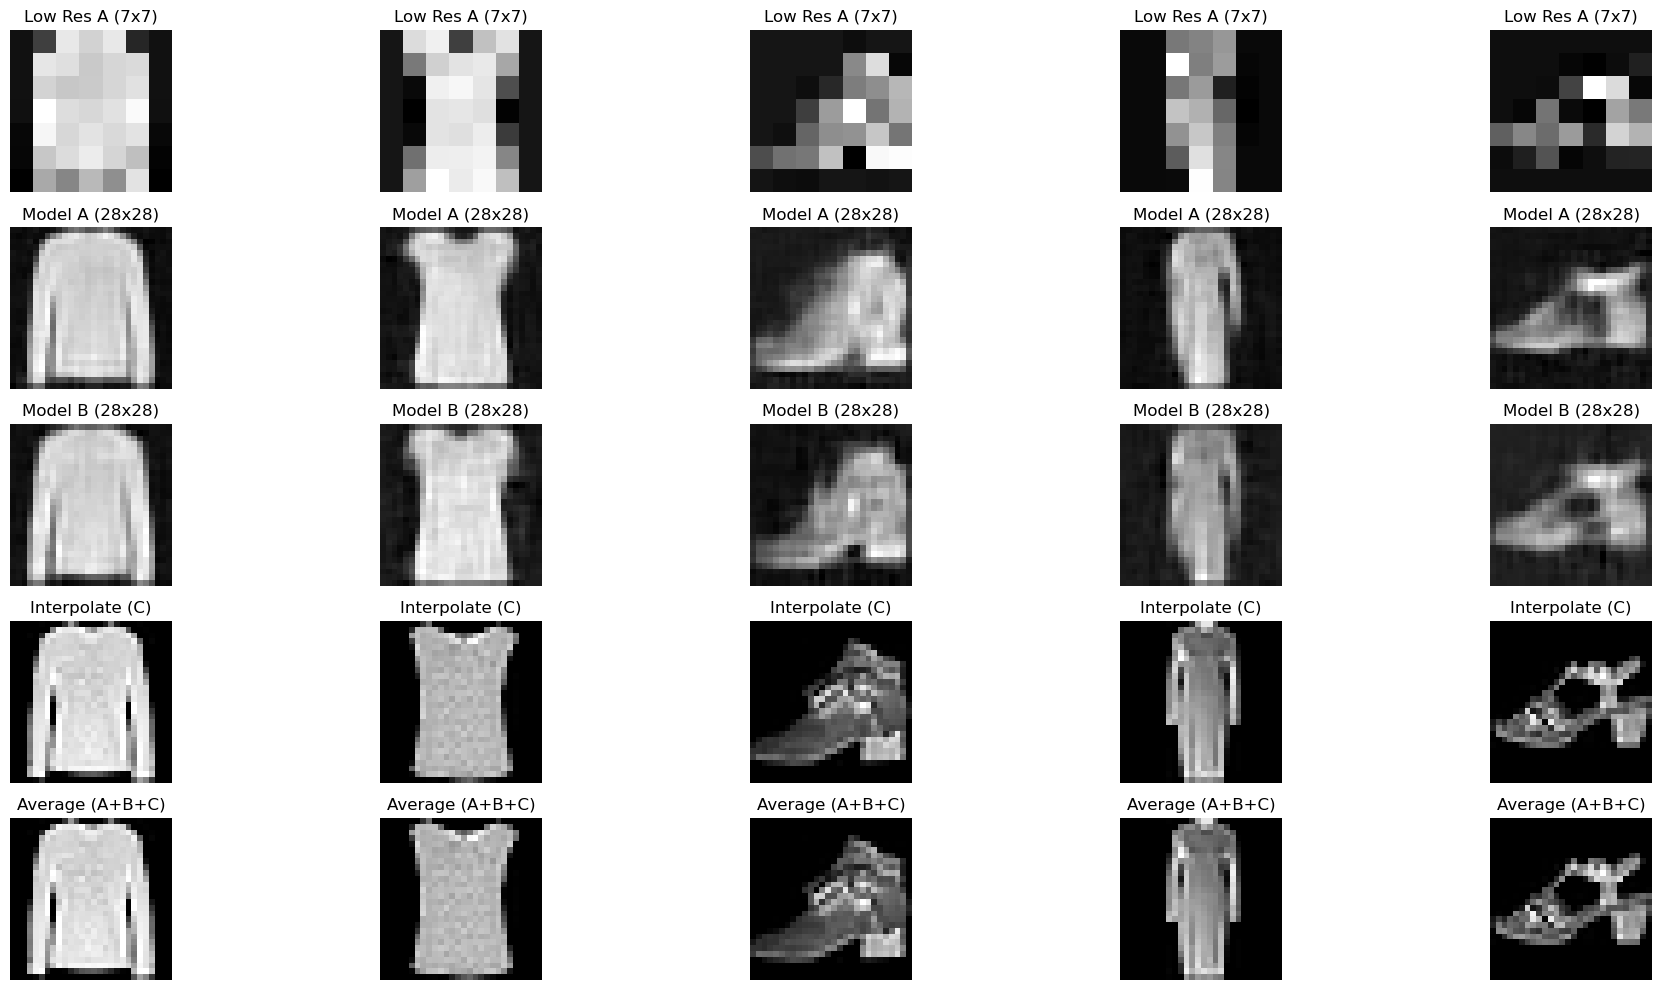

Starting stage: 112x112
[2024-12-08 19:04:42] Epoch [1/10], Loss A: 0.0002, Loss B: 0.0001
[2024-12-08 19:13:12] Epoch [2/10], Loss A: 0.0001, Loss B: 0.0001
[2024-12-08 19:21:56] Epoch [3/10], Loss A: 0.0001, Loss B: 0.0000
[2024-12-08 19:30:34] Epoch [4/10], Loss A: 0.0000, Loss B: 0.0000
[2024-12-08 19:38:50] Epoch [5/10], Loss A: 0.0000, Loss B: 0.0000
[2024-12-08 19:47:05] Epoch [6/10], Loss A: 0.0000, Loss B: 0.0000
[2024-12-08 19:55:22] Epoch [7/10], Loss A: 0.0000, Loss B: 0.0000
[2024-12-08 20:03:26] Epoch [8/10], Loss A: 0.0000, Loss B: 0.0000
[2024-12-08 20:11:02] Epoch [9/10], Loss A: 0.0000, Loss B: 0.0000
[2024-12-08 20:18:41] Epoch [10/10], Loss A: 0.0000, Loss B: 0.0000
Displaying results for resolution: 112x112


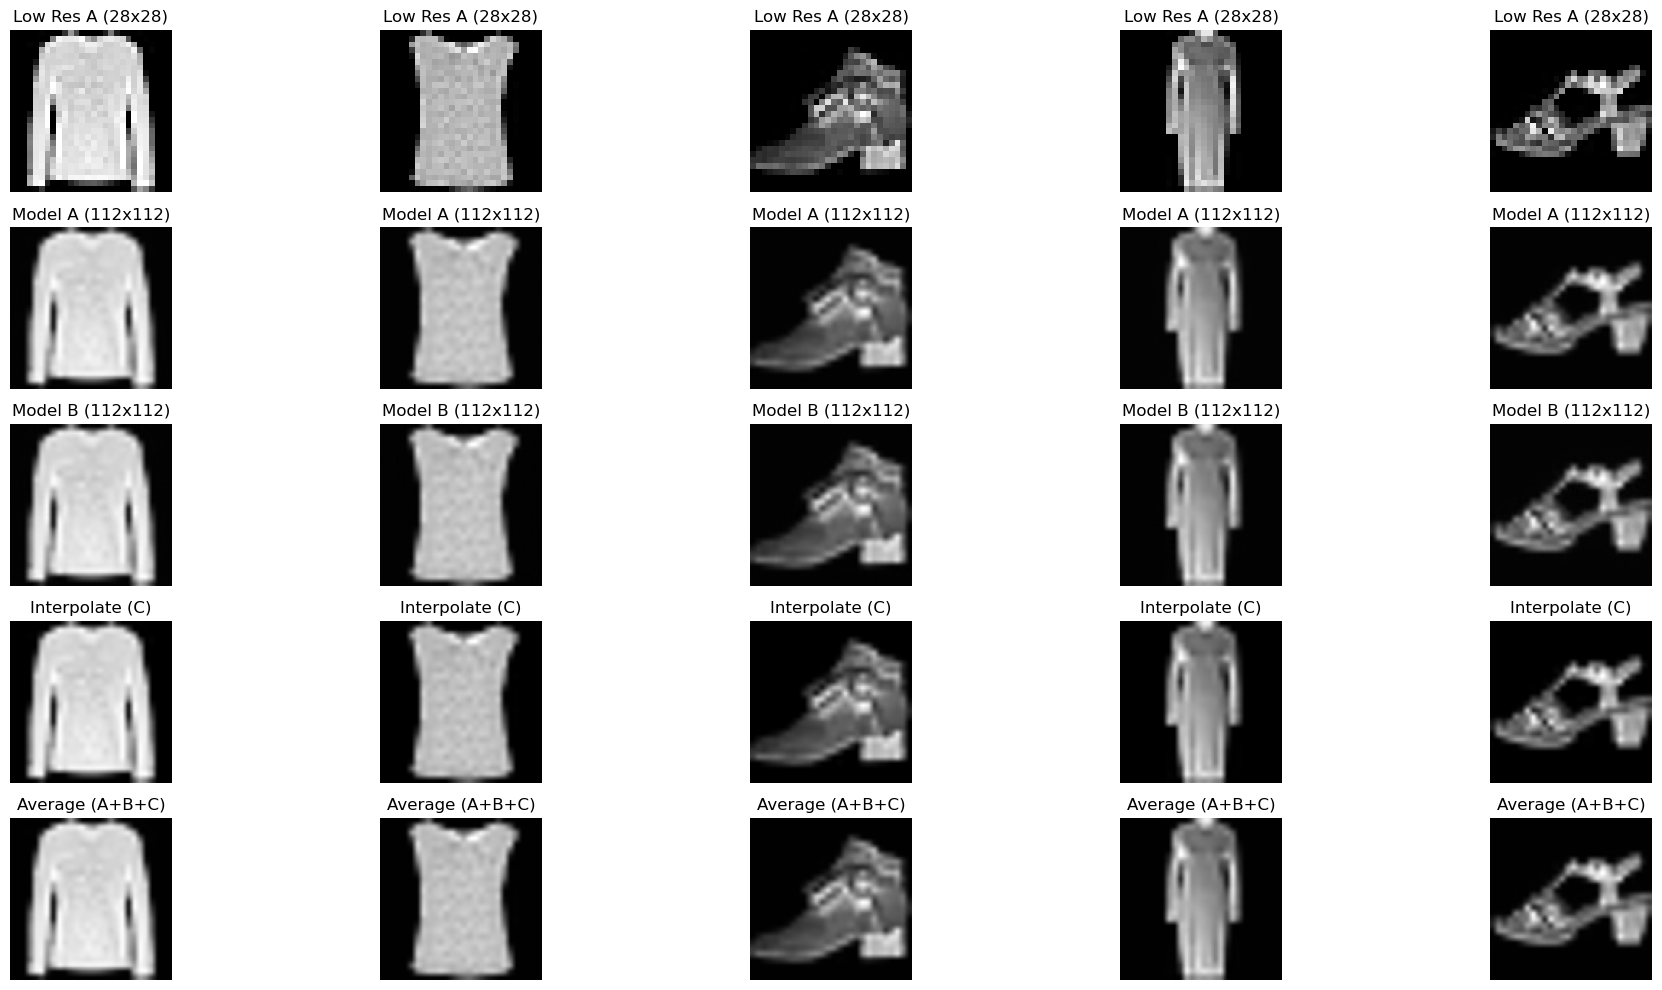

In [ ]:
import datetime
# 학습
epoch_num = 10
initial_resolution = 28
next_resolution = initial_resolution
final_resolution = 128
prev_output_a = None  # 이전 단계의 A 출력
prev_output_b = None  # 이전 단계의 B 출력
max_upscale_factor = 4  # A, B의 upscale_factor 최소 공배수

while next_resolution <= final_resolution:
    print(f"Starting stage: {next_resolution}x{next_resolution}")

    current_prev_output = []  # 이번 단계의 출력 리스트

    for epoch in range(epoch_num):  # 각 단계에서 3 에포크 학습
        for batch_idx, (data, _) in enumerate(data_loader):
            # 데이터 준비
            data = data.to(device)

            if next_resolution == initial_resolution:
                # 첫 단계에서는 원본 데이터에서 저해상도 생성
                current_resolution = next_resolution // 4
                low_res = nn.functional.interpolate(data, size=(current_resolution, current_resolution), mode='bilinear', align_corners=False)
            else:
                # 이후 단계에서는 이전 출력 이미지를 가져옴
                if batch_idx < len(prev_output):
                    low_res = prev_output[batch_idx].to(device)
                else:
                    raise IndexError("Batch index out of range for previous outputs.")

            # 모델 A와 B의 출력
            output_a_step1 = model_a(low_res)
            output_a = model_a(output_a_step1)
            output_b = model_b(low_res)

            # 보조값 C 생성
            target_resolution = output_a.shape[-2:]
            high_res_c = nn.functional.interpolate(data, size=target_resolution, mode='bilinear', align_corners=False)

            # 평균값 계산
            avg_output = data if(next_resolution == initial_resolution) else (output_a + output_b + high_res_c) / 3

            # 손실 계산
            loss_a = nn.MSELoss()(output_a, avg_output)
            loss_b = nn.MSELoss()(output_b, avg_output)
            total_loss = loss_a + loss_b

            # 모델 학습
            optimizer_a.zero_grad()
            optimizer_b.zero_grad()
            total_loss.backward()
            optimizer_a.step()
            optimizer_b.step()

            if epoch == epoch_num-1:
            # 다음 단계 출력을 저장
                if next_resolution * 4 < final_resolution :
                    if batch_idx < len(current_prev_output):
                        current_prev_output[batch_idx] = avg_output.detach()
                    else:
                        current_prev_output.append(data.detach())
                else:
                    # 마지막 단계라면 리스트를 비움
                    current_prev_output.clear()

        # 출력
        current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"[{current_time}] Epoch [{epoch+1}/{epoch_num}], Loss A: {loss_a.item():.4f}, Loss B: {loss_b.item():.4f}")

    # 학습 마지막 에포크에서 출력
    with torch.no_grad():
        print(f"Displaying results for resolution: {next_resolution}x{next_resolution}")
        plt.figure(figsize=(20, 10))
        for i in range(5):  # 5개의 샘플 출력
            # 저해상도 A
            plt.subplot(5, 5, i + 1)
            plt.imshow(low_res[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"Low Res A ({target_resolution[0] // max_upscale_factor}x{target_resolution[0] // max_upscale_factor})")
            plt.axis('off')

            # A의 결과
            plt.subplot(5, 5, i + 6)
            plt.imshow(output_a[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"Model A ({target_resolution[0]}x{target_resolution[1]})")
            plt.axis('off')

            # B의 결과
            plt.subplot(5, 5, i + 11)
            plt.imshow(output_b[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title(f"Model B ({target_resolution[0]}x{target_resolution[1]})")
            plt.axis('off')

            # 보조값 C
            plt.subplot(5, 5, i + 16)
            plt.imshow(high_res_c[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title("Interpolate (C)")
            plt.axis('off')

            # 평균값
            plt.subplot(5, 5, i + 21)
            plt.imshow(avg_output[i].squeeze().cpu().numpy(), cmap='gray')
            plt.title("Average (A+B+C)")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

    # 에포크 종료 후 메모리 캐시 정리
    torch.cuda.empty_cache()
    gc.collect()  # CPU 메모리 정리
    
    # 각 단계가 끝나면 A와 B의 출력 이미지를 다음 단계 입력으로 저장
    prev_output = current_prev_output  # 다음 단계의 저해상도로 사용

    # 다음 단계로 해상도 증가
    next_resolution *= max_upscale_factor
